In [ ]:
import pandas as pd
from pathlib import Path

def load_experiment_csv(path: Path):
    with open(path, "r") as f:
        meta_header = f.readline().strip().split(",")
        meta_values = f.readline().strip().split(",")
    meta = dict(zip(meta_header, meta_values))
    logs = pd.read_csv(path, skiprows=2)
    return meta, logs

base = Path("multirun/2025-09-21_13-55-16/default")

results = []
for csv in base.rglob("metrics.csv"):
    meta, logs = load_experiment_csv(csv)
    logs = logs.assign(**meta)  # add metadata to each row
    results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert types
df["width"] = df["width"].astype(float)
df["seed"] = df["seed"].astype(int)
df["noise"] = df["noise"].astype(float)
df["params"] = df["params"].astype(int)

# Take only the final epoch from each run
last_epoch = df.groupby(["arch", "width", "seed"]).tail(1)

# Aggregate over seeds
agg = (
    last_epoch.groupby(["arch", "width"])
    .agg(
        test_acc_mean=("test_acc", "mean"),
        test_acc_std=("test_acc", "std"),
        test_loss_mean=("test_loss", "mean"),
        test_loss_std=("test_loss", "std"),
        runs=("seed", "count"),
    )
    .reset_index()
)

# Print nicely
for _, row in agg.iterrows():
    print(
        f"{row.arch}, width={row.width:.3f}: "
        f"Acc={row.test_acc_mean:.3f} ± {row.test_acc_std:.3f} "
        f"(n={row.runs}), "
        f"Loss={row.test_loss_mean:.3f} ± {row.test_loss_std:.3f}"
    )


resnet18, width=4.000: Acc=0.780 ± 0.006 (n=2), Loss=0.729 ± 0.009
resnet18, width=12.000: Acc=0.722 ± 0.002 (n=2), Loss=1.306 ± 0.032
resnet18, width=64.000: Acc=0.840 ± nan (n=1), Loss=1.524 ± nan


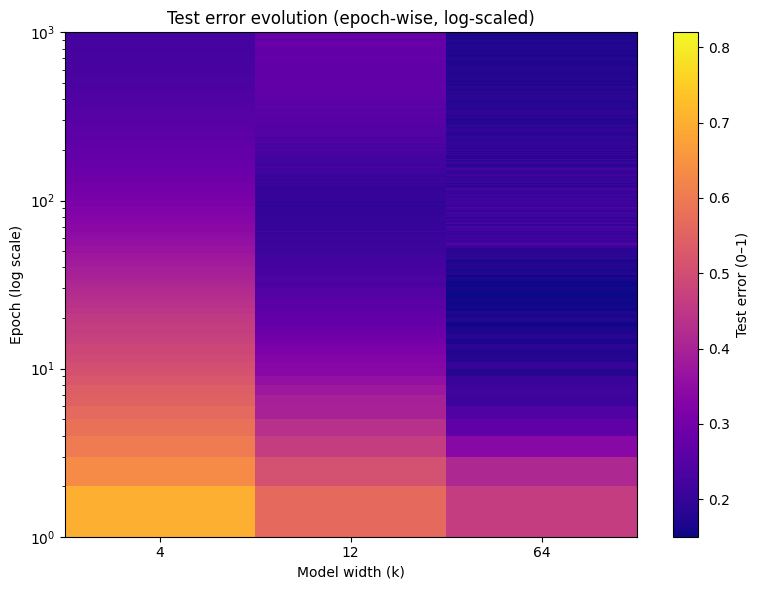

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Average across seeds, but compute error instead of accuracy
df_mean = (
    df.groupby(["width", "epoch"], as_index=False)
    .agg(test_error=("test_acc", lambda x: 1 - x.mean()))
)

# Pivot into width × epoch grid
pivot = df_mean.pivot(index="width", columns="epoch", values="test_error")

# If you only care about certain widths
selected_widths = [4, 12, 64]
pivot_sel = pivot.loc[selected_widths]

# pivot: rows = width, cols = epoch
Z = pivot_sel.T.values              # shape (n_epochs, n_widths)
epochs = pivot_sel.columns.values   # e.g. [1, 2, ..., 1000]
widths = [4, 12, 64]     # e.g. [0.0625, 0.2]

fig, ax = plt.subplots(figsize=(8, 6))

# define bin edges
X_edges = np.arange(len(widths) + 1)   # bin edges for widths
Y_edges = np.arange(epochs.min(), epochs.max() + 2)  # bin edges for epochs

X, Y = np.meshgrid(X_edges, Y_edges)

# fixed color scale from 0 to 1
c = ax.pcolormesh(X, Y, Z, cmap="plasma", shading="auto", vmin=0.15, vmax=0.82)

# log y-axis for epochs
ax.set_yscale("log")
ax.set_ylabel("Epoch (log scale)")
ax.set_xlabel("Model width (k)")

# ticks at bin centers
ax.set_xticks(np.arange(len(widths)) + 0.5)
ax.set_xticklabels(widths)

# colorbar
fig.colorbar(c, ax=ax, label="Test error (0–1)")
plt.title("Test error evolution (epoch-wise, log-scaled)")
plt.tight_layout()
plt.show()

![WhatsApp Image 2025-09-22 at 15.19.54_ca7aac01.jpg](<attachment:WhatsApp Image 2025-09-22 at 15.19.54_ca7aac01.jpg>)
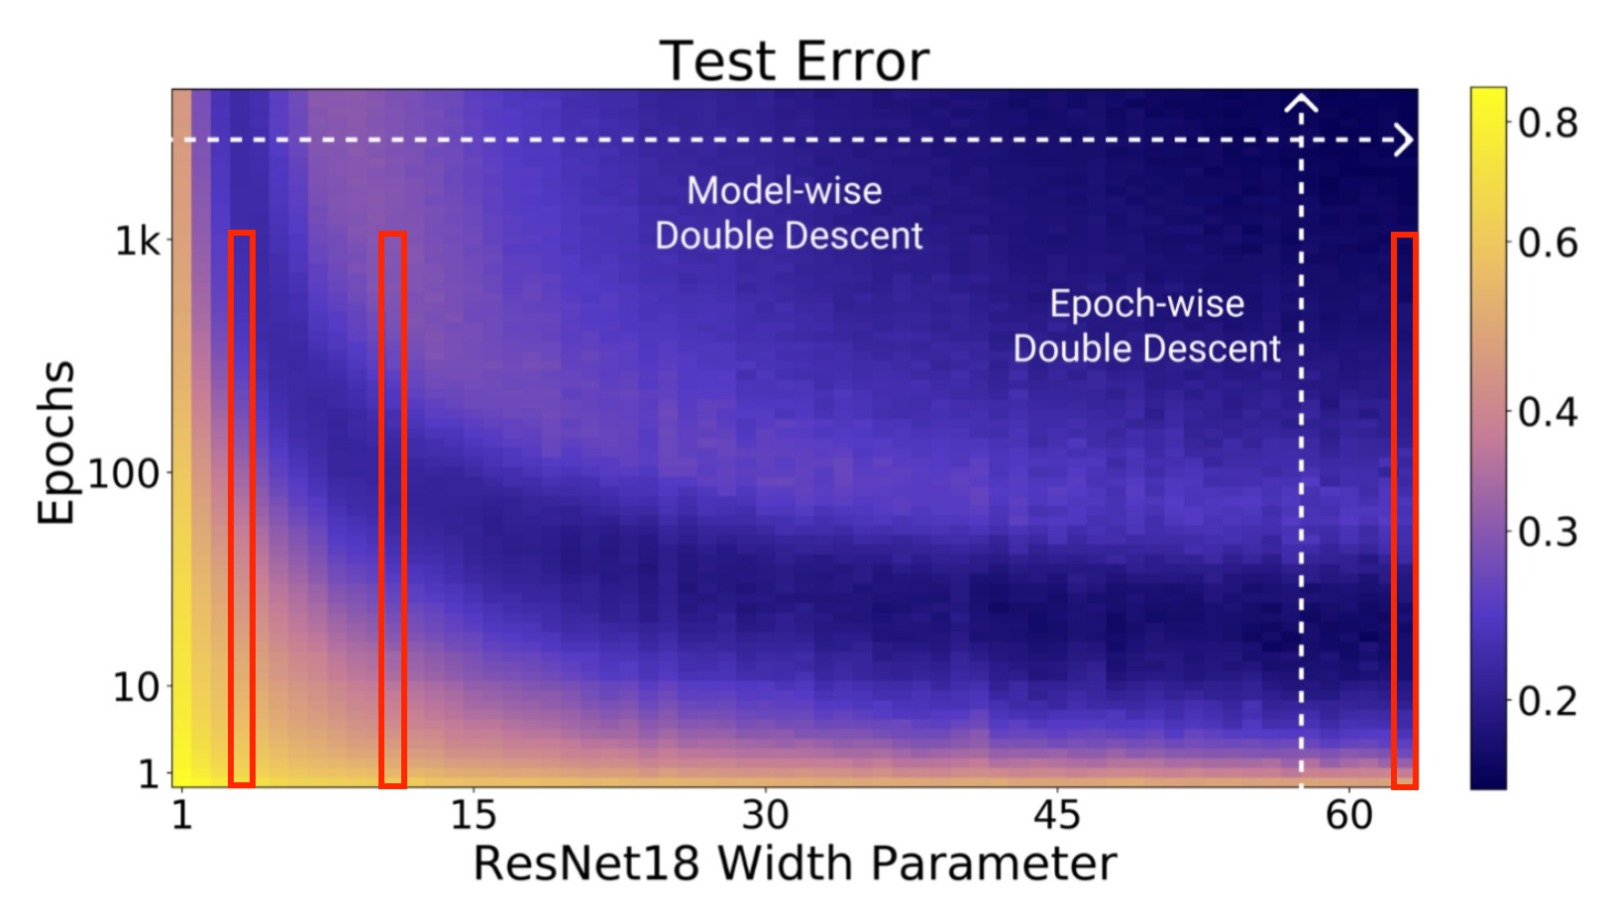

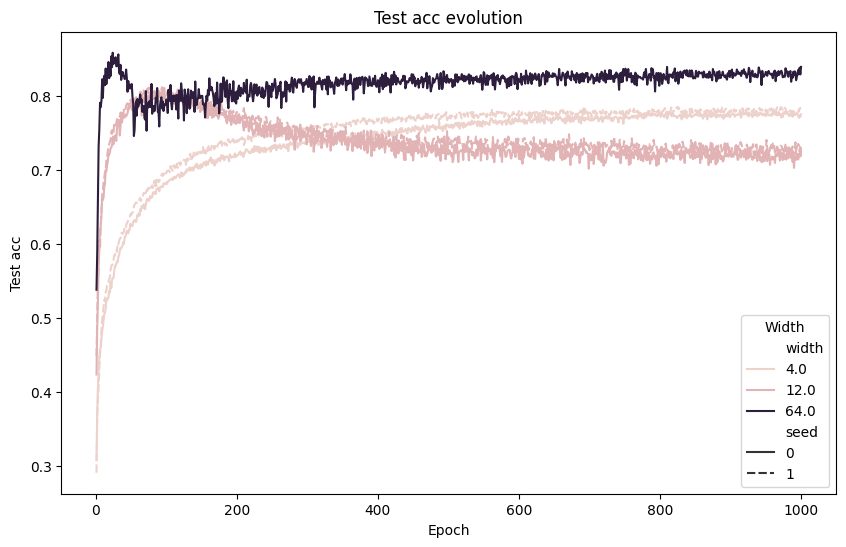

C:\Users\luord\AppData\Local\Temp\ipykernel_33912\777776916.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


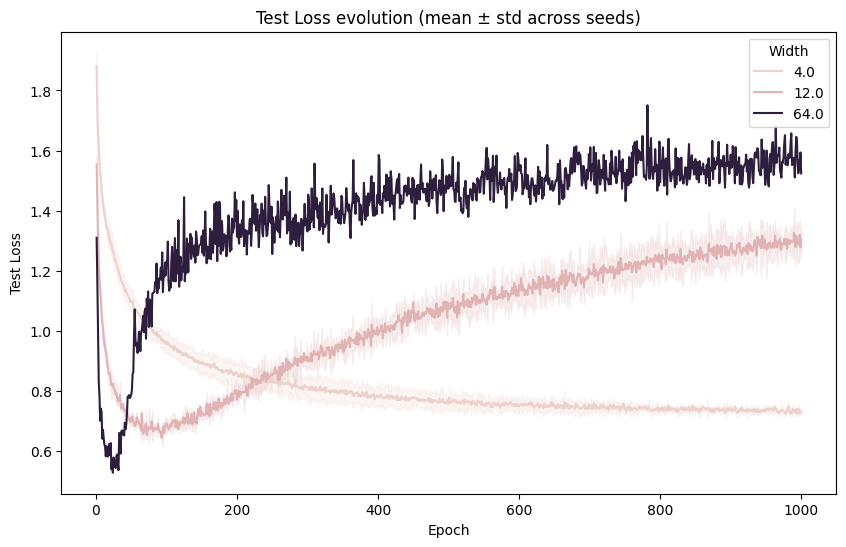

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="test_acc",
    hue="width", style="seed",
    estimator=None  # plot each seed separately
)
plt.title("Test acc evolution")
plt.ylabel("Test acc")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="test_loss",
    hue="width",
    ci="sd"  # shaded std deviation across seeds
)
plt.title("Test Loss evolution (mean ± std across seeds)")
plt.ylabel("Test Loss")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

C:\Users\luord\AppData\Local\Temp\ipykernel_33912\94895203.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


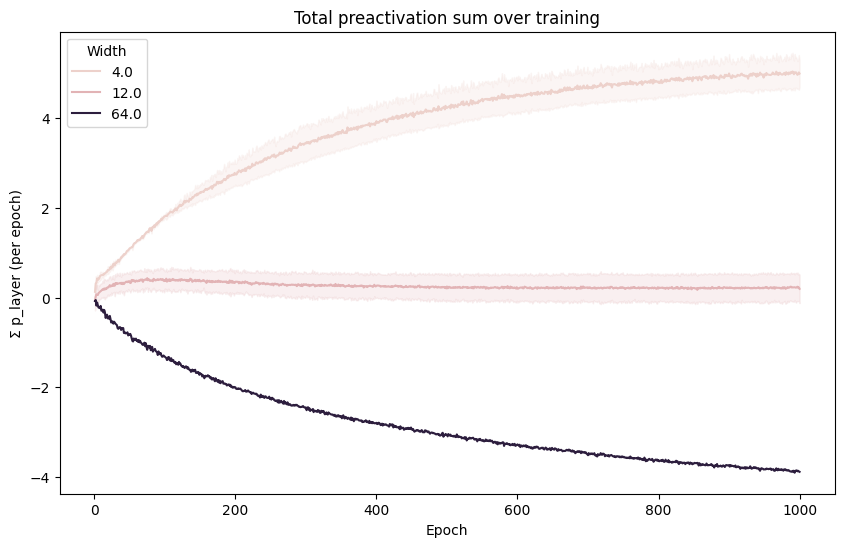

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

p_layer_cols = [c for c in df.columns if c.startswith("p_layer")]
df["p_sum"] = df[p_layer_cols].sum(axis=1)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="p_sum",
    hue="width",
    ci="sd"  # std deviation across seeds
)
plt.title("Total preactivation sum over training")
plt.ylabel("Σ p_layer (per epoch)")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()


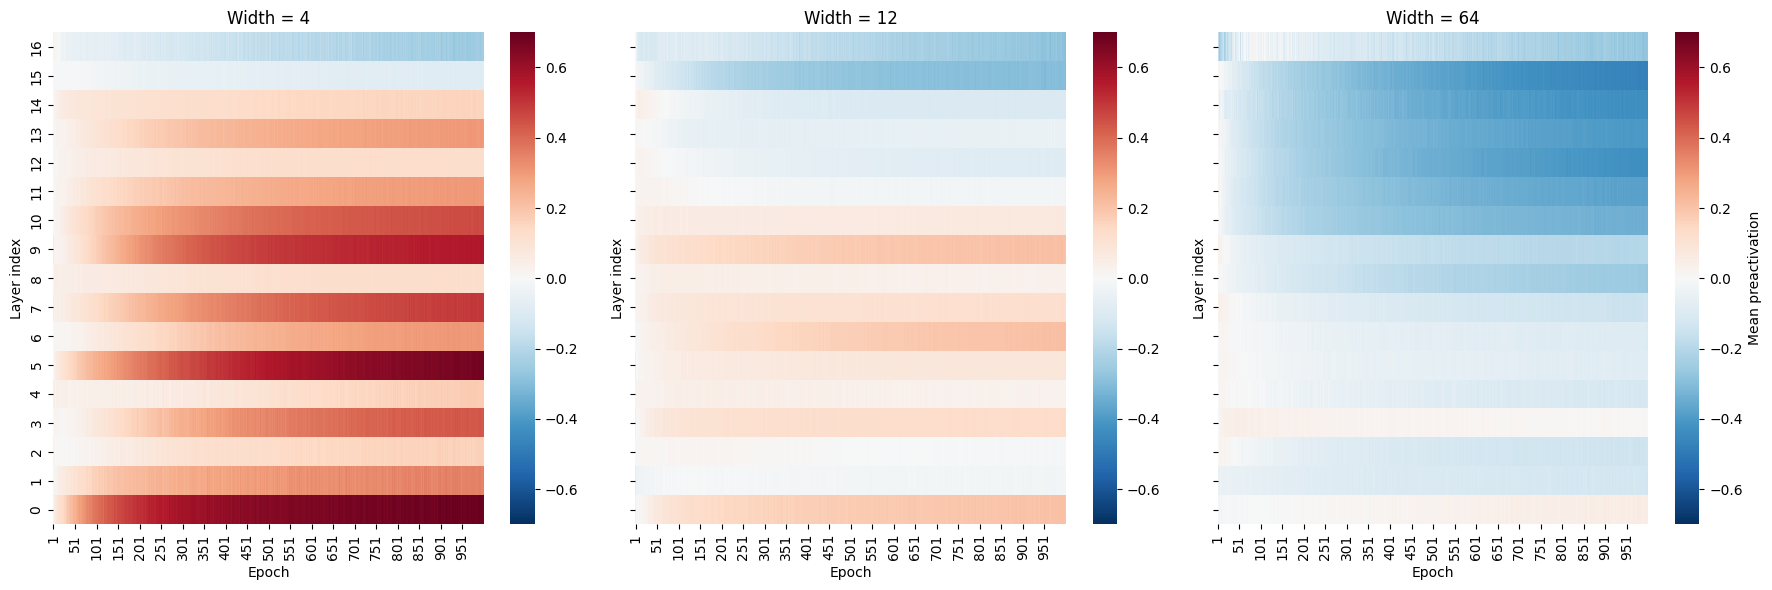

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def load_experiment_csv(path: Path):
    with open(path, "r") as f:
        meta_header = f.readline().strip().split(",")
        meta_values = f.readline().strip().split(",")
    meta = dict(zip(meta_header, meta_values))
    logs = pd.read_csv(path, skiprows=2)
    return meta, logs

# --- Load experiments ---
base = Path("multirun/2025-09-21_13-55-16/default")

results = []
for csv in base.rglob("metrics.csv"):
    meta, logs = load_experiment_csv(csv)
    logs = logs.assign(**meta)  # add metadata to each row
    results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert metadata types
df["width"] = pd.to_numeric(df["width"], errors="coerce")
df["seed"] = pd.to_numeric(df["seed"], errors="coerce").astype("Int64")
df["noise"] = pd.to_numeric(df["noise"], errors="coerce")
df["params"] = pd.to_numeric(df["params"], errors="coerce").astype("Int64")

# --- List of widths to plot ---
widths = [4, 12, 64]

# --- Prepare figure ---
fig, axes = plt.subplots(1, len(widths), figsize=(6 * len(widths), 6), sharey=True)

for ax, w in zip(axes, widths):
    df_w = df[df["width"] == w]

    p_layer_cols = [c for c in df_w.columns if c.startswith("p_layer")]
    df_long = df_w.melt(
        id_vars=["epoch", "seed"],
        value_vars=p_layer_cols,
        var_name="layer",
        value_name="p_value"
    )
    df_long["layer"] = df_long["layer"].str.replace("p_layer", "").astype(int)

    df_long_mean = (
        df_long.groupby(["layer", "epoch"], as_index=False)
        .agg(p_value=("p_value", "mean"))
    )

    pivot = df_long_mean.pivot(index="layer", columns="epoch", values="p_value")

    sns.heatmap(
        pivot,
        cmap="RdBu_r", center=0,
        vmin=-.7, vmax=.7,
        cbar_kws={"label": "Mean preactivation"} if ax == axes[-1] else None,
        xticklabels=50, ax=ax
    )
    ax.set_title(f"Width = {w}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Layer index")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from pathlib import Path

def load_experiment_csv(path: Path):
    with open(path, "r") as f:
        meta_header = f.readline().strip().split(",")
        meta_values = f.readline().strip().split(",")
    meta = dict(zip(meta_header, meta_values))
    logs = pd.read_csv(path, skiprows=2)
    return meta, logs

base = Path("multirun/2025-09-22_16-29-28/default")

results = []
for csv in base.rglob("metrics.csv"):
    meta, logs = load_experiment_csv(csv)
    logs = logs.assign(**meta)  # add metadata to each row
    results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert types
df["width"] = df["width"].astype(float)
df["seed"] = df["seed"].astype(int)
df["noise"] = df["noise"].astype(float)
df["params"] = df["params"].astype(int)

# Take only the final epoch from each run
last_epoch = df.groupby(["arch", "width", "seed"]).tail(1)

# Aggregate over seeds
agg = (
    last_epoch.groupby(["arch", "width"])
    .agg(
        test_acc_mean=("test_acc", "mean"),
        test_acc_std=("test_acc", "std"),
        test_loss_mean=("test_loss", "mean"),
        test_loss_std=("test_loss", "std"),
        runs=("seed", "count"),
    )
    .reset_index()
)

# Print nicely
for _, row in agg.iterrows():
    print(
        f"{row.arch}, width={row.width:.3f}: "
        f"Acc={row.test_acc_mean:.3f} ± {row.test_acc_std:.3f} "
        f"(n={row.runs}), "
        f"Loss={row.test_loss_mean:.3f} ± {row.test_loss_std:.3f}"
    )


simplecnn, width=7.000: Acc=0.782 ± 0.003 (n=2), Loss=0.704 ± 0.000
simplecnn, width=20.000: Acc=0.768 ± 0.005 (n=2), Loss=0.721 ± 0.019
simplecnn, width=75.000: Acc=0.843 ± 0.010 (n=2), Loss=0.511 ± 0.036


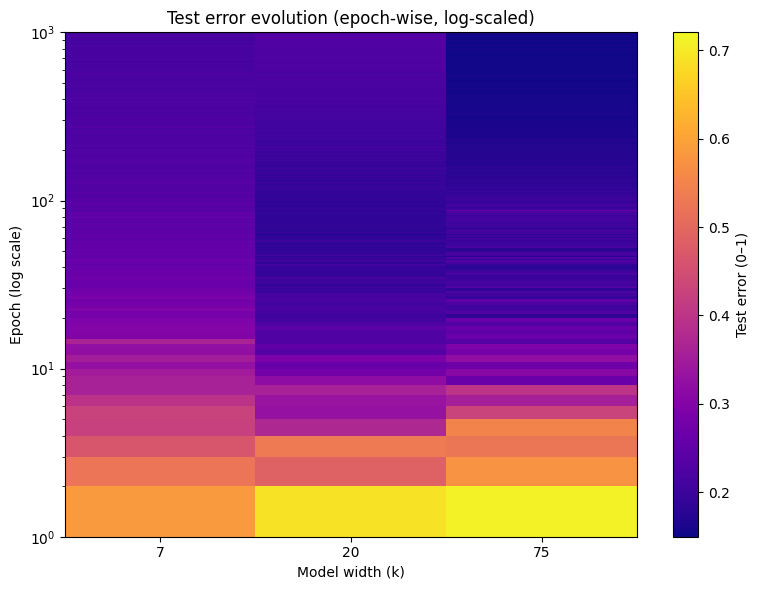

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Average across seeds, but compute error instead of accuracy
df_mean = (
    df.groupby(["width", "epoch"], as_index=False)
    .agg(test_error=("test_acc", lambda x: 1 - x.mean()))
)

# Pivot into width × epoch grid
pivot = df_mean.pivot(index="width", columns="epoch", values="test_error")

# If you only care about certain widths
selected_widths = [7, 20, 75]
pivot_sel = pivot.loc[selected_widths]

# pivot: rows = width, cols = epoch
Z = pivot_sel.T.values      # shape (n_epochs, n_widths)
epochs = pivot_sel.columns.values   # e.g. [1, 2, ..., 1000]
widths = [7, 20, 75]     # e.g. [0.0625, 0.2]

fig, ax = plt.subplots(figsize=(8, 6))

# define bin edges
X_edges = np.arange(len(widths) + 1)   # bin edges for widths
Y_edges = np.arange(epochs.min(), epochs.max() + 2)  # bin edges for epochs

X, Y = np.meshgrid(X_edges, Y_edges)

# fixed color scale from 0 to 1
c = ax.pcolormesh(X, Y, Z, cmap="plasma", shading="auto", vmin=0.15, vmax=0.72)

# log y-axis for epochs
ax.set_yscale("log")
ax.set_ylabel("Epoch (log scale)")
ax.set_xlabel("Model width (k)")

# ticks at bin centers
ax.set_xticks(np.arange(len(widths)) + 0.5)
ax.set_xticklabels(widths)

# colorbar
fig.colorbar(c, ax=ax, label="Test error (0–1)")
plt.title("Test error evolution (epoch-wise, log-scaled)")
plt.tight_layout()
plt.show()

![WhatsApp Image 2025-10-03 at 13.34.58_d4d0a3bb.jpg](<attachment:WhatsApp Image 2025-10-03 at 13.34.58_d4d0a3bb.jpg>)
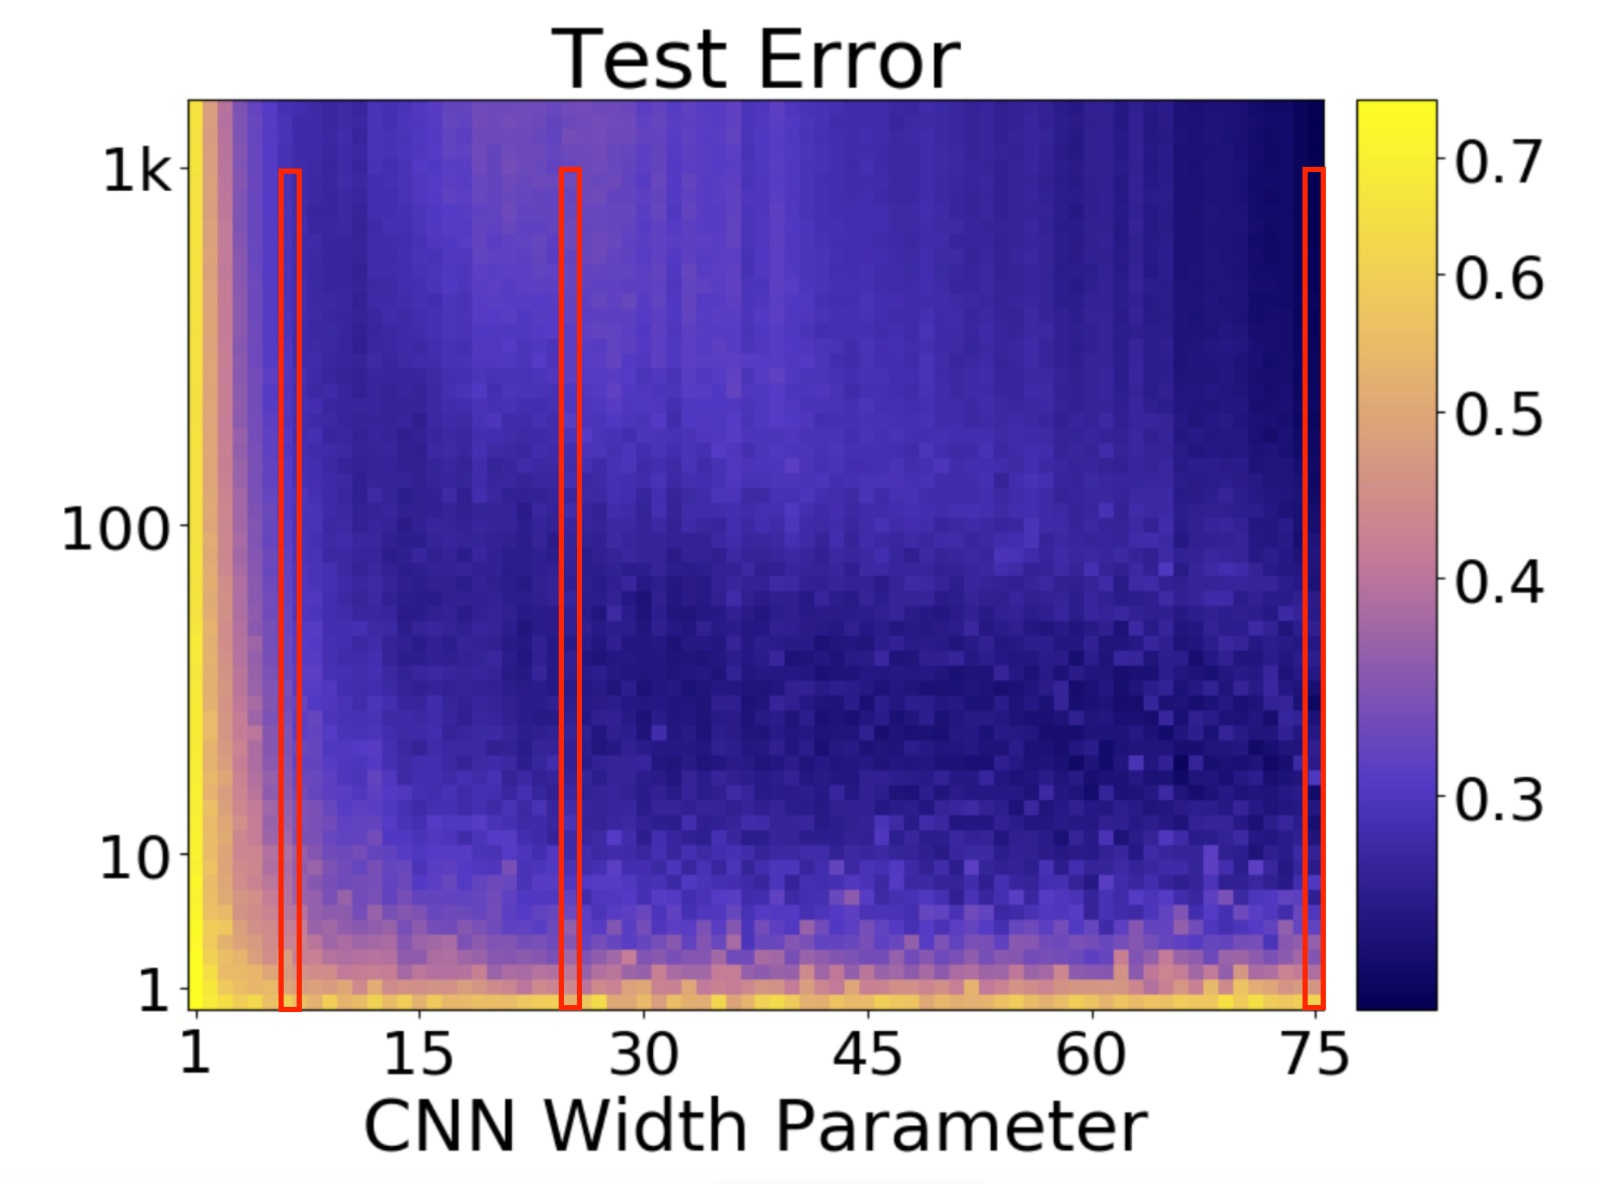

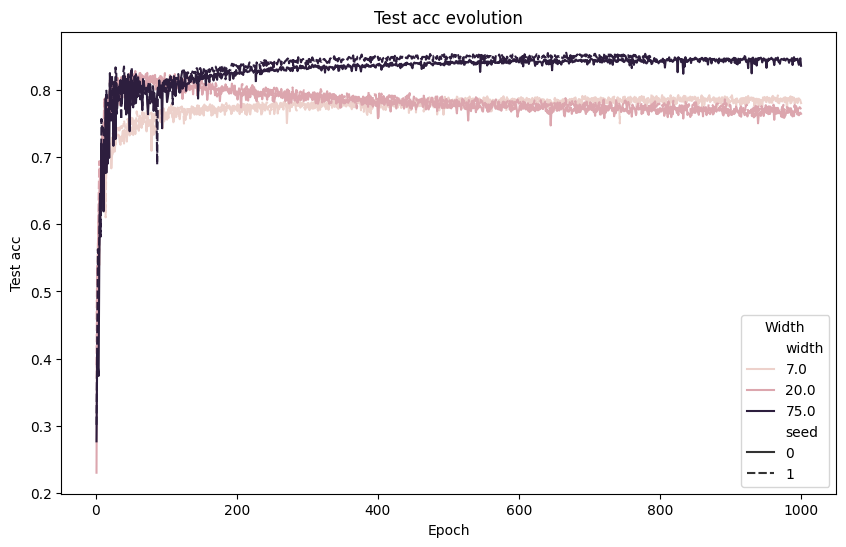

C:\Users\luord\AppData\Local\Temp\ipykernel_25160\777776916.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


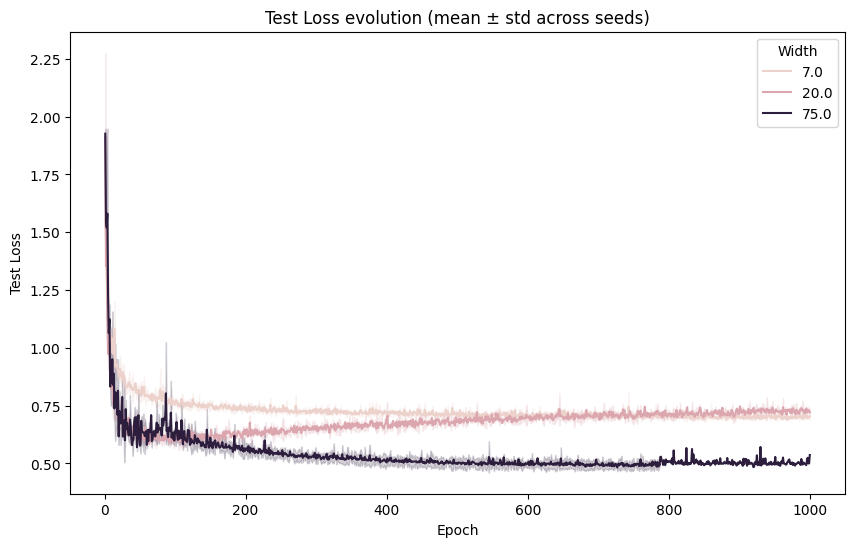

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: plot test loss for each width, each seed
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="test_acc",
    hue="width", style="seed",
    estimator=None  # plot each seed separately
)
plt.title("Test acc evolution")
plt.ylabel("Test acc")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="test_loss",
    hue="width",
    ci="sd"  # shaded std deviation across seeds
)
plt.title("Test Loss evolution (mean ± std across seeds)")
plt.ylabel("Test Loss")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

C:\Users\luord\AppData\Local\Temp\ipykernel_25160\94895203.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


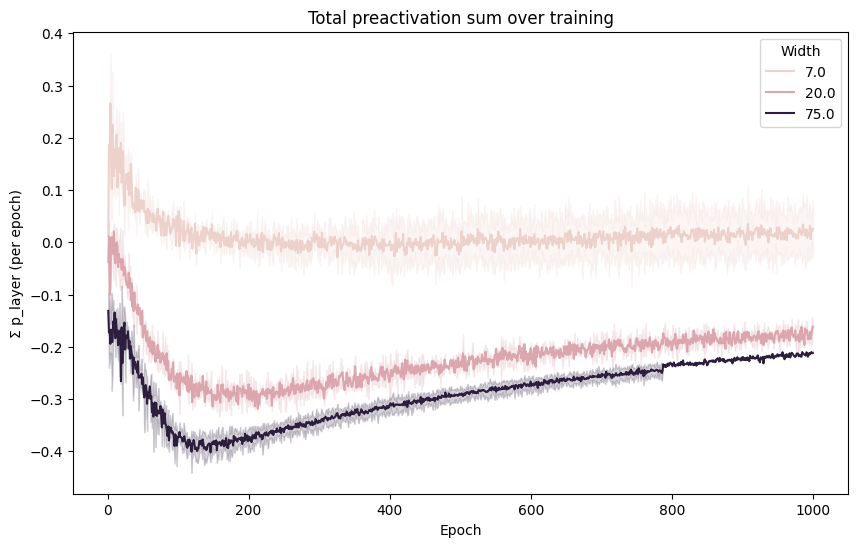

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

p_layer_cols = [c for c in df.columns if c.startswith("p_layer")]
df["p_sum"] = df[p_layer_cols].sum(axis=1)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="p_sum",
    hue="width",
    ci="sd"  # std deviation across seeds
)
plt.title("Total preactivation sum over training")
plt.ylabel("Σ p_layer (per epoch)")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()


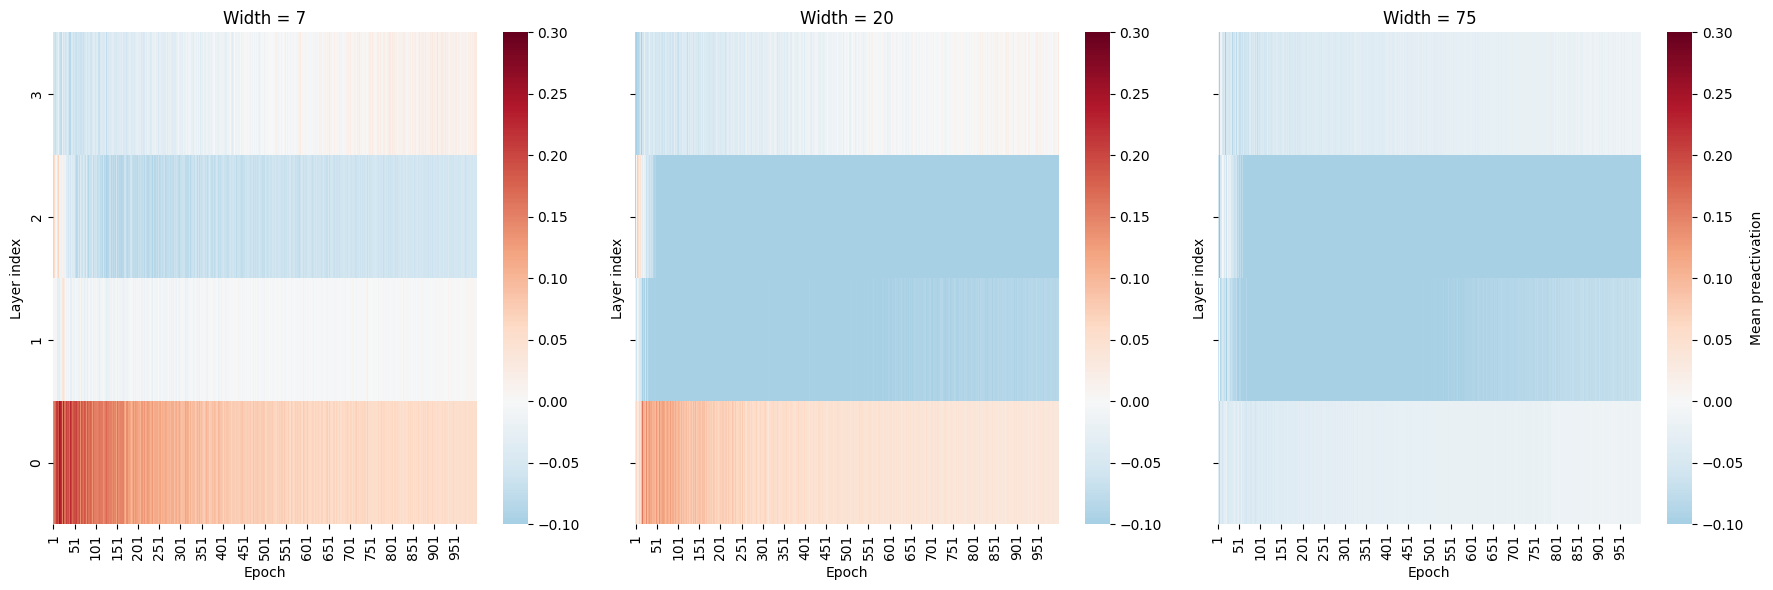

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def load_experiment_csv(path: Path):
    with open(path, "r") as f:
        meta_header = f.readline().strip().split(",")
        meta_values = f.readline().strip().split(",")
    meta = dict(zip(meta_header, meta_values))
    logs = pd.read_csv(path, skiprows=2)
    return meta, logs

# --- Load experiments ---
base = Path("multirun/2025-09-22_16-29-28/default")

results = []
for csv in base.rglob("metrics.csv"):
    meta, logs = load_experiment_csv(csv)
    logs = logs.assign(**meta)  # add metadata to each row
    results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert metadata types
df["width"] = pd.to_numeric(df["width"], errors="coerce")
df["seed"] = pd.to_numeric(df["seed"], errors="coerce").astype("Int64")
df["noise"] = pd.to_numeric(df["noise"], errors="coerce")
df["params"] = pd.to_numeric(df["params"], errors="coerce").astype("Int64")

# --- List of widths to plot ---
widths = [7, 20, 75]

# --- Prepare figure ---
fig, axes = plt.subplots(1, len(widths), figsize=(6 * len(widths), 6), sharey=True)

for ax, w in zip(axes, widths):
    df_w = df[df["width"] == w]

    p_layer_cols = [c for c in df_w.columns if c.startswith("p_layer")]
    df_long = df_w.melt(
        id_vars=["epoch", "seed"],
        value_vars=p_layer_cols,
        var_name="layer",
        value_name="p_value"
    )
    df_long["layer"] = df_long["layer"].str.replace("p_layer", "").astype(int)

    df_long_mean = (
        df_long.groupby(["layer", "epoch"], as_index=False)
        .agg(p_value=("p_value", "mean"))
    )

    pivot = df_long_mean.pivot(index="layer", columns="epoch", values="p_value")

    sns.heatmap(
        pivot,
        cmap="RdBu_r", center=0,
        vmin=-.1, vmax=.3,
        cbar_kws={"label": "Mean preactivation"} if ax == axes[-1] else None,
        xticklabels=50, ax=ax
    )
    ax.set_title(f"Width = {w}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Layer index")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from pathlib import Path

def load_experiment_csv(path: Path):
    # read meta line
    with open(path, "r") as f:
        meta_header = f.readline().strip().split(",")
        meta_values = f.readline().strip().split(",")
    meta = dict(zip(meta_header, meta_values))
    logs = pd.read_csv(path, skiprows=2)
    return meta, logs

base = Path("multirun/2025-10-09_10-32-00/default")

results = []
for csv in base.rglob("metrics.csv"):
    meta, logs = load_experiment_csv(csv)
    logs = logs.assign(**meta)  
    results.append(logs)

df = pd.concat(results, ignore_index=True)


df["width"] = df["width"].astype(float)
df["seed"] = df["seed"].astype(int)
df["noise"] = df["noise"].astype(float)
df["params"] = df["params"].astype(int)

# Take only the final epoch from each run
last_epoch = df.groupby(["arch", "width", "seed"]).tail(1)

# Aggregate over seeds
agg = (
    last_epoch.groupby(["arch", "width"])
    .agg(
        test_acc_mean=("test_acc", "mean"),
        test_acc_std=("test_acc", "std"),
        test_loss_mean=("test_loss", "mean"),
        test_loss_std=("test_loss", "std"),
        runs=("seed", "count"),
    )
    .reset_index()
)

# Print nicely
for _, row in agg.iterrows():
    print(
        f"{row.arch}, width={row.width:.3f}: "
        f"Acc={row.test_acc_mean:.3f} ± {row.test_acc_std:.3f} "
        f"(n={row.runs}), "
        f"Loss={row.test_loss_mean:.3f} ± {row.test_loss_std:.3f}"
    )


transformer, width=96.000: Acc=0.573 ± nan (n=1), Loss=3.658 ± nan
transformer, width=200.000: Acc=0.558 ± 0.002 (n=2), Loss=4.080 ± 0.017
transformer, width=400.000: Acc=0.579 ± 0.000 (n=2), Loss=4.185 ± 0.022


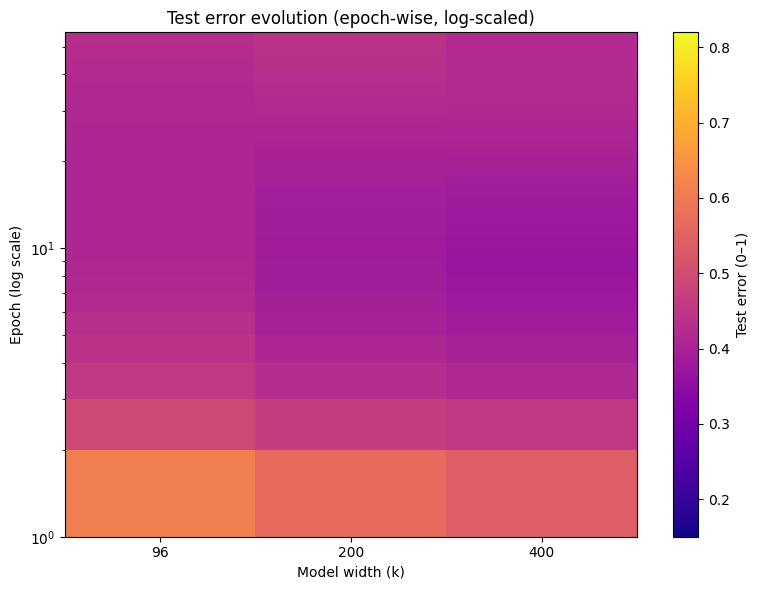

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Average across seeds, but compute error instead of accuracy
df_mean = (
    df.groupby(["width", "epoch"], as_index=False)
    .agg(test_error=("test_acc", lambda x: 1 - x.mean()))
)

# Pivot into width × epoch grid
pivot = df_mean.pivot(index="width", columns="epoch", values="test_error")

# If you only care about certain widths
selected_widths = [96,200,400]
pivot_sel = pivot.loc[selected_widths]

# pivot: rows = width, cols = epoch
Z = pivot_sel.T.values              # shape (n_epochs, n_widths)
epochs = pivot_sel.columns.values   # e.g. [1, 2, ..., 1000]
widths = [96,200,400]     # e.g. [0.0625, 0.2]

fig, ax = plt.subplots(figsize=(8, 6))

# define bin edges
X_edges = np.arange(len(widths) + 1)   # bin edges for widths
Y_edges = np.arange(epochs.min(), epochs.max() + 2)  # bin edges for epochs

X, Y = np.meshgrid(X_edges, Y_edges)

# fixed color scale from 0 to 1
c = ax.pcolormesh(X, Y, Z, cmap="plasma", shading="auto", vmin=0.15, vmax=0.82)

# log y-axis for epochs
ax.set_yscale("log")
ax.set_ylabel("Epoch (log scale)")
ax.set_xlabel("Model width (k)")

# ticks at bin centers
ax.set_xticks(np.arange(len(widths)) + 0.5)
ax.set_xticklabels(widths)

# colorbar
fig.colorbar(c, ax=ax, label="Test error (0–1)")
plt.title("Test error evolution (epoch-wise, log-scaled)")
plt.tight_layout()
plt.show()

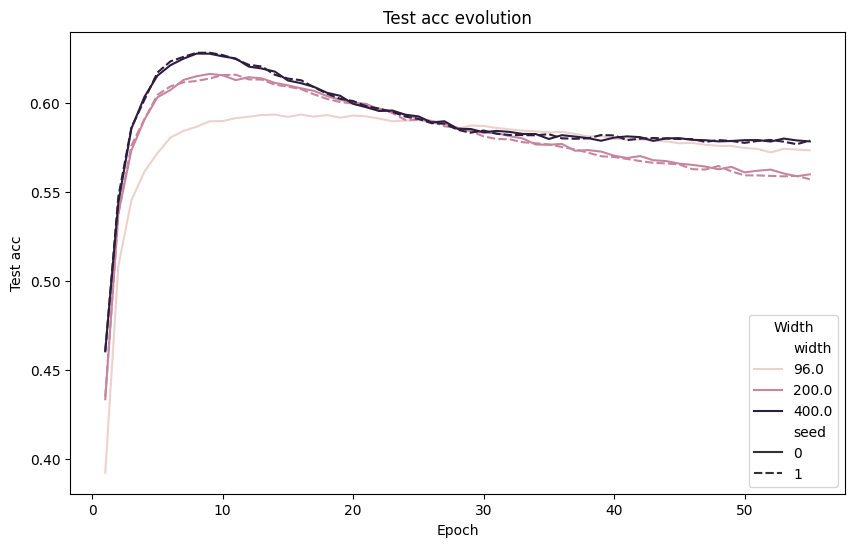

C:\Users\luord\AppData\Local\Temp\ipykernel_23016\777776916.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


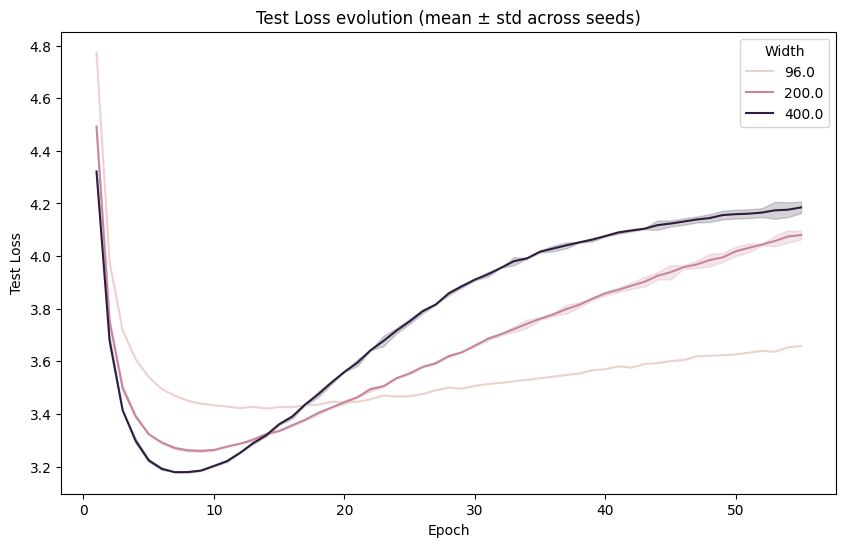

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="test_acc",
    hue="width", style="seed",
    estimator=None  # plot each seed separately
)
plt.title("Test acc evolution")
plt.ylabel("Test acc")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="test_loss",
    hue="width",
    ci="sd"  # shaded std deviation across seeds
)
plt.title("Test Loss evolution (mean ± std across seeds)")
plt.ylabel("Test Loss")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

![alt text](image.png)

0      -2.967866
1      -9.664155
2     -12.324845
3     -13.664699
4     -13.551253
         ...    
270   -11.612378
271   -11.675490
272   -11.760969
273   -11.651975
274   -11.802335
Name: p_sum, Length: 275, dtype: float64


C:\Users\luord\AppData\Local\Temp\ipykernel_23016\1965288521.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


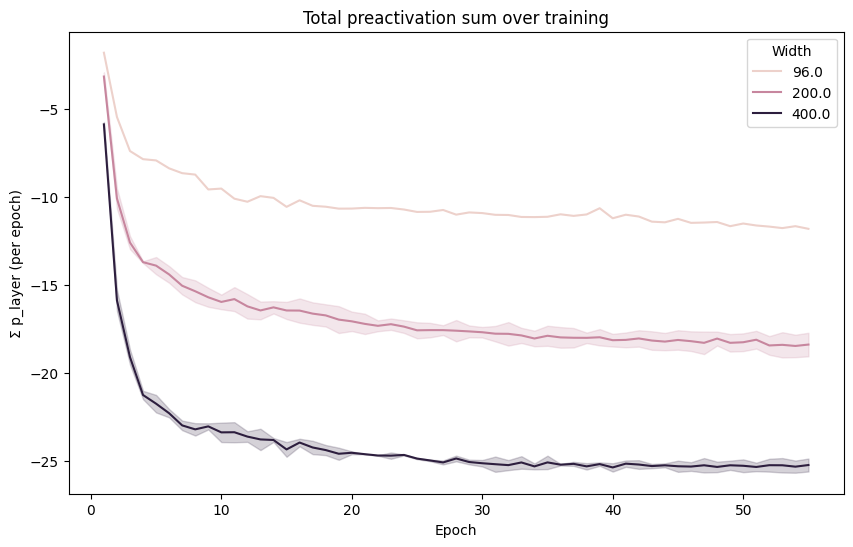

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

p_layer_cols = [c for c in df.columns if c.startswith("p_dec_layer")]
df["p_sum"] = df[p_layer_cols].sum(axis=1)
print(df["p_sum"])

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="p_sum",
    hue="width",
    ci="sd"  
)
plt.title("Total preactivation sum over training")
plt.ylabel("Σ p_layer (per epoch)")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

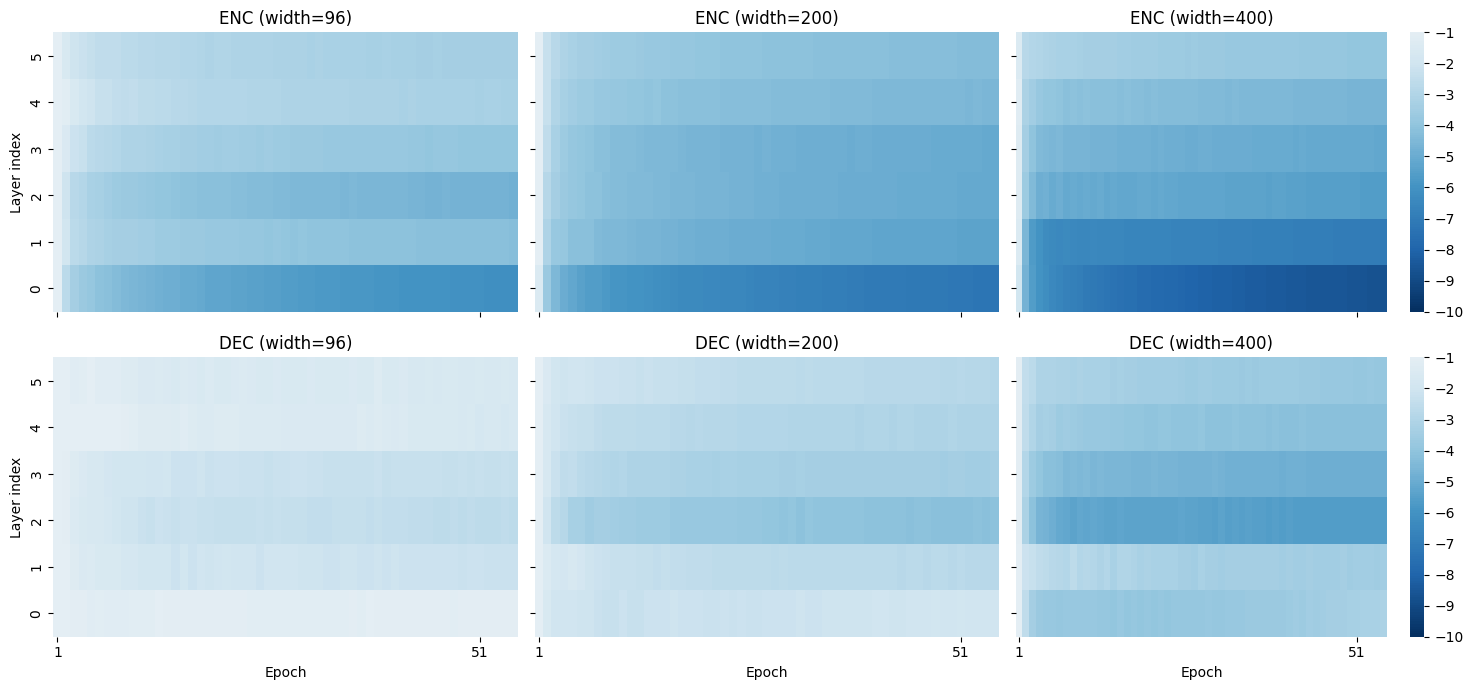

In [18]:
# --- Prepare figure ---
n_widths = len(widths)
layer_types = ["enc", "dec"]

fig, axes = plt.subplots(2, n_widths, figsize=(15, 7), sharey=True, sharex=True)

for col, w in enumerate(widths):
    df_w = df[df["width"] == w]

    p_layer_cols = [c for c in df_w.columns if c.startswith("p_")]

    df_long = df_w.melt(
        id_vars=["epoch", "seed"],
        value_vars=p_layer_cols,
        var_name="layer",
        value_name="p_value"
    )

    df_long["layer_type"] = df_long["layer"].apply(lambda x: re.findall(r"p_(enc|dec)", x)[0])
    df_long["layer_idx"] = df_long["layer"].apply(lambda x: int(re.findall(r"layer(\d+)", x)[0]))

    df_long_mean = (
        df_long.groupby(["layer_type", "layer_idx", "epoch"], as_index=False)
        .agg(p_value=("p_value", "mean"))
    )

    for row, ltype in enumerate(layer_types):
        df_sub = df_long_mean[df_long_mean["layer_type"] == ltype]
        if df_sub.empty:
            continue
        pivot = df_sub.pivot(index="layer_idx", columns="epoch", values="p_value")

        sns.heatmap(
            pivot,
            cmap="RdBu_r",
            center=0,
            xticklabels=50,
            vmin=-10,
            vmax=-1,
            ax=axes[row, col],
            cbar=(col == n_widths - 1),  # show colorbar only on last column
        )

        axes[row, col].invert_yaxis()
        axes[row, col].set_xlabel("Epoch" if row == 1 else "")
        axes[row, col].set_ylabel("Layer index" if col == 0 else "")

        title = f"{ltype.upper()} (width={w})"
        axes[row, col].set_title(title)

plt.tight_layout()
plt.show()
